<a href="https://colab.research.google.com/github/M-Borsuk/SuicidesRateAnalysis/blob/main/SuicideRates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install plotly
!pip install wordcloud
!pip install joypy


In [27]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import json
import plotly.express as px
from wordcloud import WordCloud,STOPWORDS
import random
from plotly.colors import n_colors
from PIL import Image
import joypy
from matplotlib import cm
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import neighbors
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scipy import stats
from scipy.stats import norm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


In [28]:
#For the jupyterLab
pio.renderers.default = "notebook_connected"
#For google colab
#pio.renderers.default = "colab"

In [29]:
df = pd.read_csv('/content/drive/My Drive/master.csv')
df.head()

country  year  ... gdp_per_capita ($)       generation
0  Albania  1987  ...                796     Generation X
1  Albania  1987  ...                796           Silent
2  Albania  1987  ...                796     Generation X
3  Albania  1987  ...                796  G.I. Generation
4  Albania  1987  ...                796          Boomers

[5 rows x 12 columns]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [31]:
df.describe()

year   suicides_no  ...  HDI for year  gdp_per_capita ($)
count  27820.000000  27820.000000  ...   8364.000000        27820.000000
mean    2001.258375    242.574407  ...      0.776601        16866.464414
std        8.469055    902.047917  ...      0.093367        18887.576472
min     1985.000000      0.000000  ...      0.483000          251.000000
25%     1995.000000      3.000000  ...      0.713000         3447.000000
50%     2002.000000     25.000000  ...      0.779000         9372.000000
75%     2008.000000    131.000000  ...      0.855000        24874.000000
max     2016.000000  22338.000000  ...      0.944000       126352.000000

[8 rows x 6 columns]

In [32]:
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [33]:
df["HDI for year"].isna().value_counts()

True     19456
False     8364
Name: HDI for year, dtype: int64

In [34]:
df = df.drop(columns="country-year")

In [35]:
df.columns = ["country","year","sex","age","num_of_suicides","population","suicides_per_100k", 'HDI_for_year',
       'gdp_for_year($)', 'gdp_per_capita($)', 'generation']

In [36]:
df['gdp_for_year($)'] = df['gdp_for_year($)'].apply(lambda x: pd.to_numeric(x.replace(',',"")))

In [37]:
def make_pivot_for_country(*country):
  p_table = pd.pivot_table(df,values=['suicides_per_100k'],index = ['country','sex',"year"],columns= ['age'])
  return p_table.loc[[c for c in country]]

In [38]:
make_pivot_for_country("Ukraine")

suicides_per_100k              ...                      
age                       15-24 years 25-34 years  ... 55-74 years 75+ years
country sex    year                                ...                      
Ukraine female 1987              3.70        4.45  ...       16.87     26.76
               1988              5.31        4.52  ...       16.68     25.31
               1989              5.26        5.47  ...       15.65     25.88
               1990              4.78        5.20  ...       15.10     23.11
               1991              3.92        4.89  ...       14.55     24.63
               1992              5.35        5.99  ...       14.98     19.96
               1993              4.26        6.08  ...       14.83     27.02
               1994              4.88        6.32  ...       16.81     27.98
               1995              5.20        6.81  ...       15.75     23.60
               1996              4.59        7.11  ...       16.44     22.34
               1997              4.80        7.23  ...       17.69     24.07
               1998              5.46        6.46  ...       18.11     24.95
               1999              4.37        7.32  ...       16.16     25.28
               2000              5.40        7.42  ...       15.92     23.58
               2001              4.03        6.41  ...       13.28     20.28
               2002              3.90        6.55  ...       13.12     18.70
               2003              3.58        6.41  ...       12.97     18.97
               2004              2.98        5.45  ...       10.68     18.10
               2005              3.83        5.38  ...       10.22     16.21
               2006              2.74        5.01  ...        9.99     15.60
               2007              3.67        5.32  ...        8.52     15.29
               2008              3.47        5.29  ...        8.43     16.63
               2009              4.53        5.32  ...        9.57     15.38
               2010              4.93        4.81  ...        8.17     15.02
               2011              5.28        4.48  ...        9.40     15.19
               2012              4.47        5.16  ...        8.95     16.28
               2014              4.90        5.72  ...        8.47     15.39
               2015              5.13        4.91  ...        7.24     13.09
        male   1987             13.77       35.55  ...       52.95     77.28
               1988             14.08       35.50  ...       48.28     77.63
               1989             16.33       40.68  ...       52.95     85.89
               1990             17.29       38.82  ...       53.65     71.76
               1991             17.23       38.54  ...       53.86     72.26
               1992             17.17       42.17  ...       57.67     83.39
               1993             21.67       45.53  ...       63.15     91.94
               1994             23.76       48.62  ...       73.57     96.42
               1995             25.47       52.45  ...       80.11     95.19
               1996             27.48       53.86  ...       86.90     88.58
               1997             26.63       53.97  ...       85.48     83.52
               1998             28.34       53.27  ...       83.84     78.78
               1999             28.33       52.40  ...       83.74     70.38
               2000             29.35       50.43  ...       83.81     70.30
               2001             28.58       47.00  ...       76.65     69.80
               2002             26.39       50.30  ...       70.00     76.60
               2003             26.10       49.09  ...       69.00     73.38
               2004             24.77       44.55  ...       59.36     66.49
               2005             22.75       43.53  ...       56.71     70.08
               2006             22.38       42.91  ...       52.69     68.11
               2007             26.87       45.27  ...       50.68     62.29
               2

In [39]:
df.head()

country  year     sex  ... gdp_for_year($)  gdp_per_capita($)       generation
0  Albania  1987    male  ...      2156624900                796     Generation X
1  Albania  1987    male  ...      2156624900                796           Silent
2  Albania  1987  female  ...      2156624900                796     Generation X
3  Albania  1987    male  ...      2156624900                796  G.I. Generation
4  Albania  1987    male  ...      2156624900                796          Boomers

[5 rows x 11 columns]

In [40]:
low_countries = df[(df['suicides_per_100k'] == 0)]["country"].value_counts()[:16].index.tolist()
for country in low_countries:
  print(df.shape)
  df.drop(df[df["country"] == country].index,inplace=True)

(27820, 11)
(27496, 11)
(27186, 11)
(26886, 11)
(26586, 11)
(26310, 11)
(25974, 11)
(25638, 11)
(25266, 11)
(25050, 11)
(24798, 11)
(24594, 11)
(24294, 11)
(23912, 11)
(23744, 11)
(23624, 11)


In [41]:
df["country"].unique()

array(['Albania', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Brazil', 'Bulgaria', 'Cabo Verde', 'Canada', 'Chile', 'Colombia',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Denmark', 'Dominica', 'Ecuador', 'El Salvador', 'Estonia', 'Fiji',
       'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Guatemala',
       'Guyana', 'Hungary', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg',
       'Macau', 'Mauritius', 'Mexico', 'Mongolia', 'Montenegro',
       'Netherlands', 'New Zealand', 'Nicaragua', 'Norway', 'Oman',
       'Panama', 'Paraguay', 'Philippines', 'Poland', 'Portugal',
       'Puerto Rico', 'Qatar', 'Republic of Korea', 'Romania',
       'Russian Federation', 'Saint Kitts and Nevis', 'San Marino',
       'Serbia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa',
       'Spain', 'Sri Lanka', 'Surina

In [42]:
df.shape

(23492, 11)

In [43]:
df["age"] = df["age"].apply(lambda x: x.split(' ')[0])
def age_helper(x):
  try:
    temp = pd.to_numeric(x.split("-"))  
    return np.floor(np.average(temp))
  except:
    return int(x[:2])
df["age"] = df["age"].apply(age_helper)
df["age"] = df["age"].astype('int64')

In [44]:
df.sex = df.sex.apply(lambda x: 0 if x == "male" else 1)

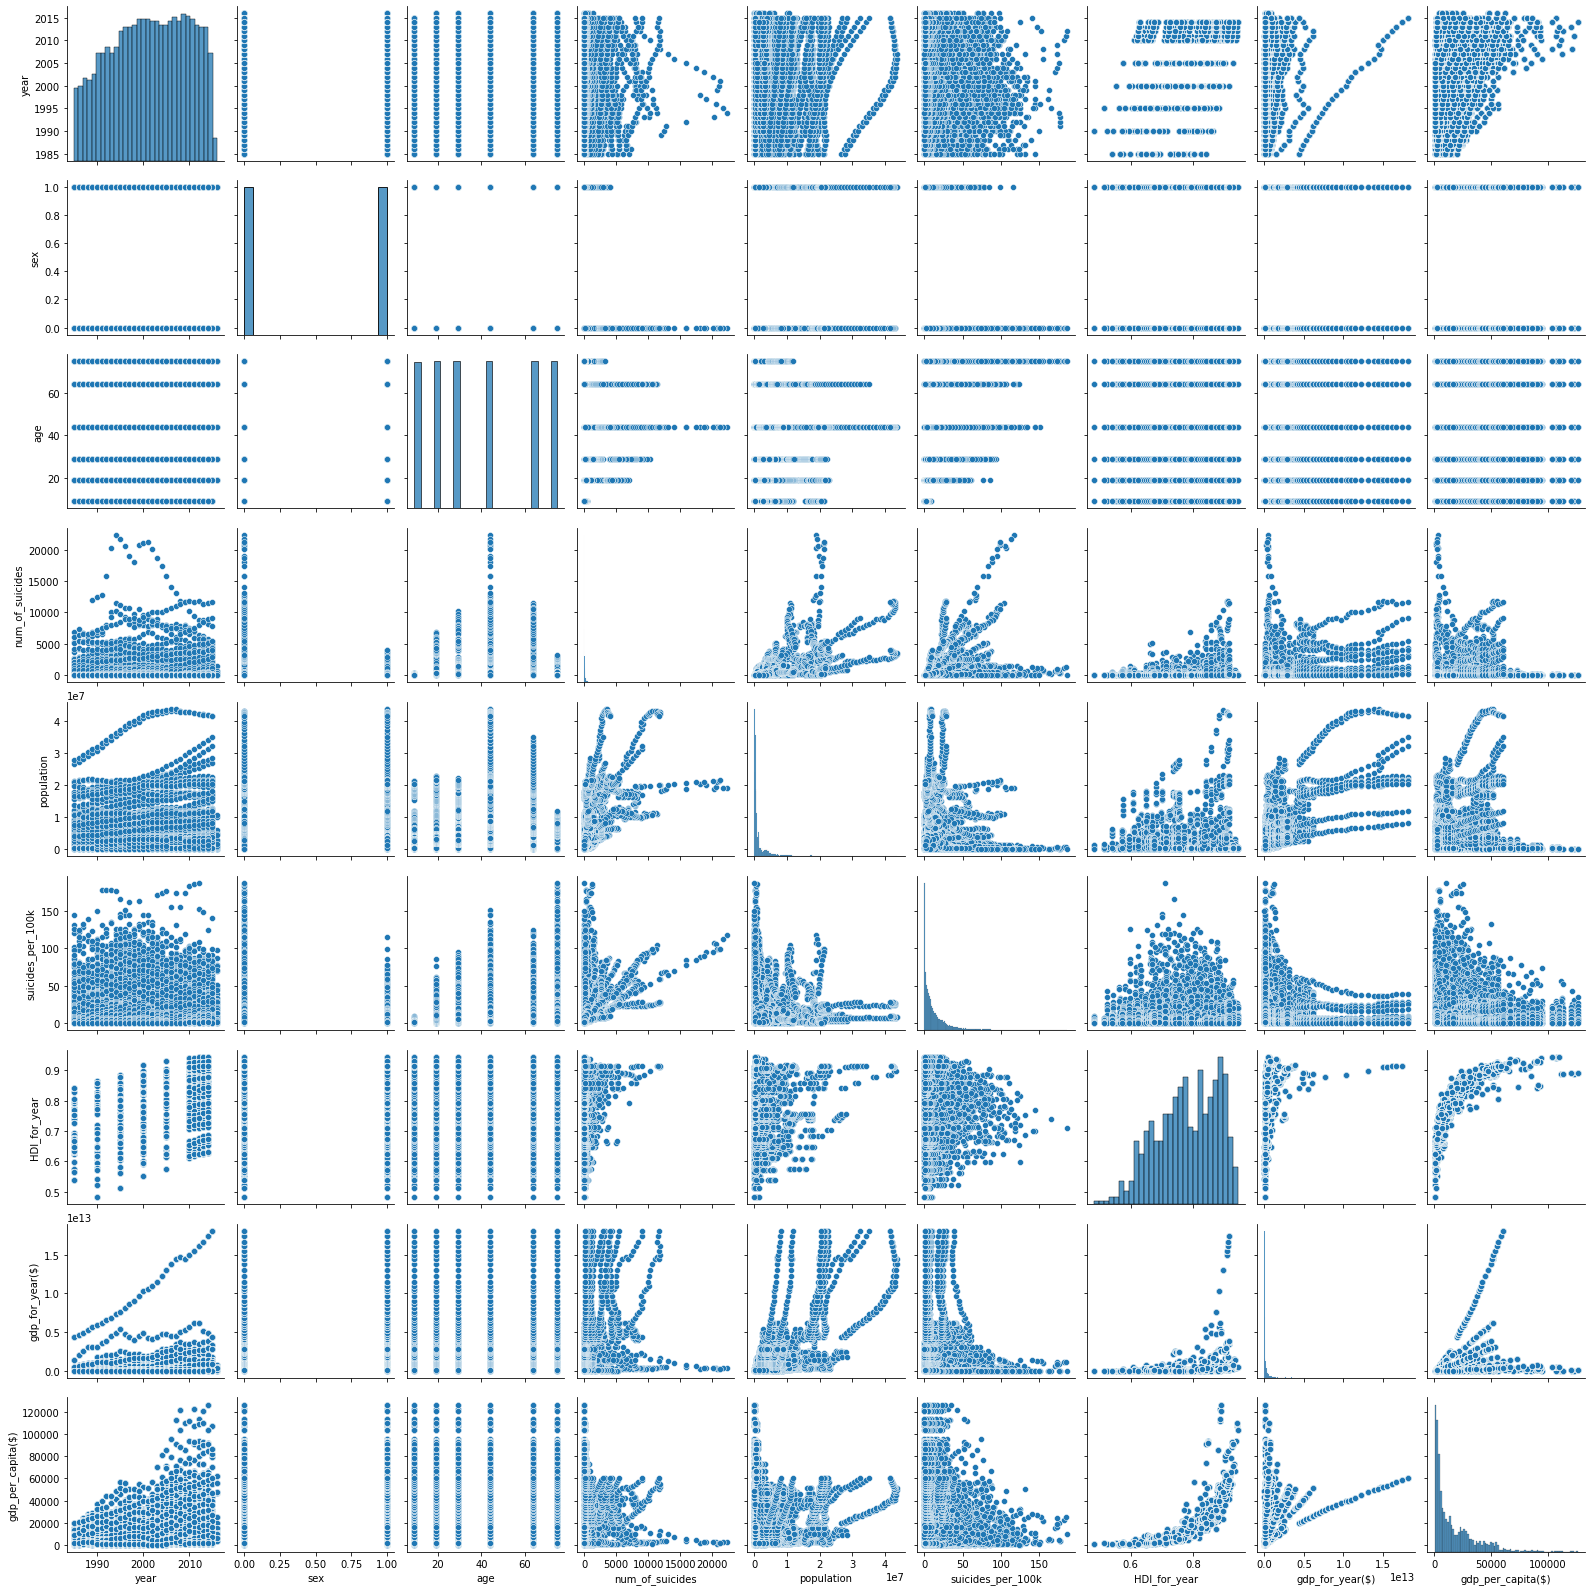

In [45]:
sns.pairplot(df)

In [46]:
df = df.drop(df[df["suicides_per_100k"] == 0].index)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



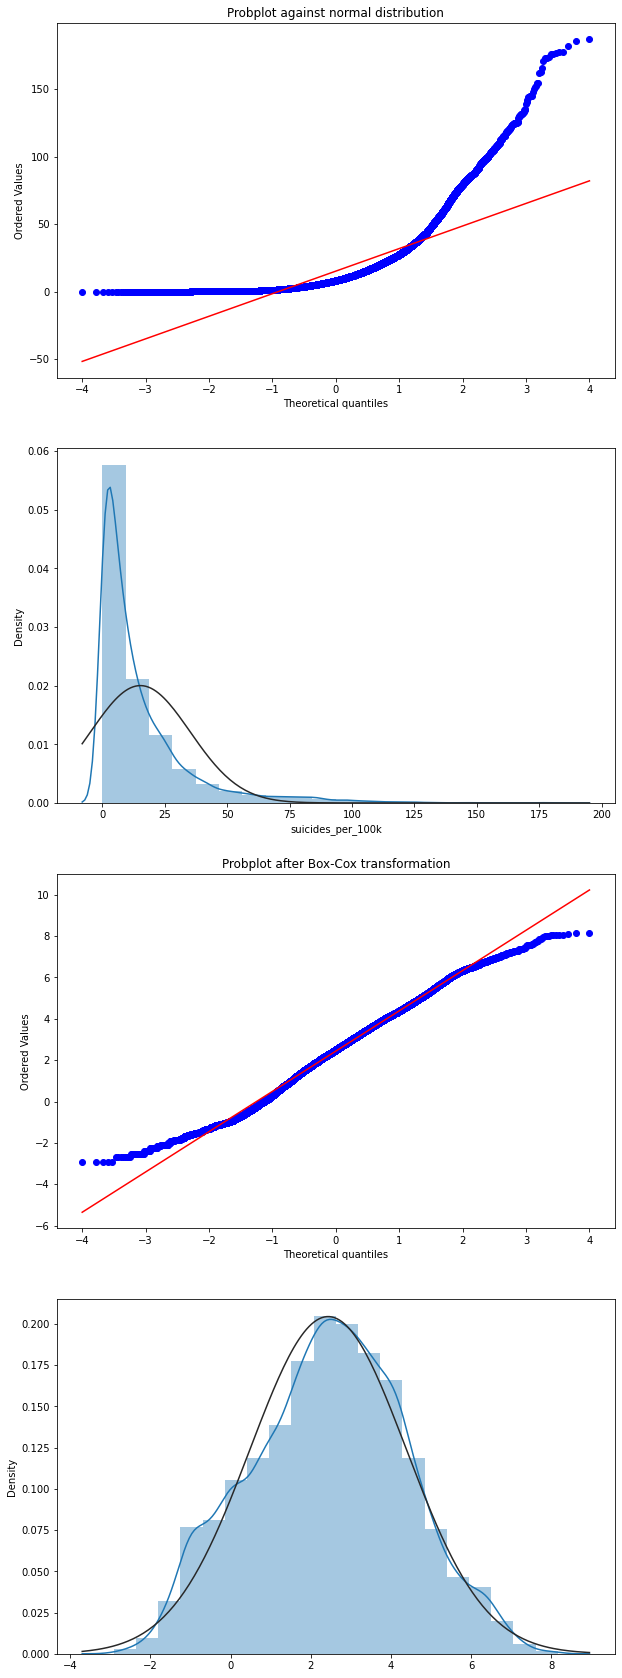

In [47]:
fig = plt.figure(figsize=(10,30))
ax1 = fig.add_subplot(411)
stats.probplot(df["suicides_per_100k"], dist=stats.norm,plot=ax1)
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(412)
sns.distplot(df["suicides_per_100k"],bins = 20,fit=norm)
ax3 = fig.add_subplot(413)
x, _ = stats.boxcox(df["suicides_per_100k"])
stats.probplot(x, dist=stats.norm,plot=ax3)
ax3.set_title('Probplot after Box-Cox transformation')
ax4 = fig.add_subplot(414)
sns.distplot(x,bins = 20,fit=norm)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



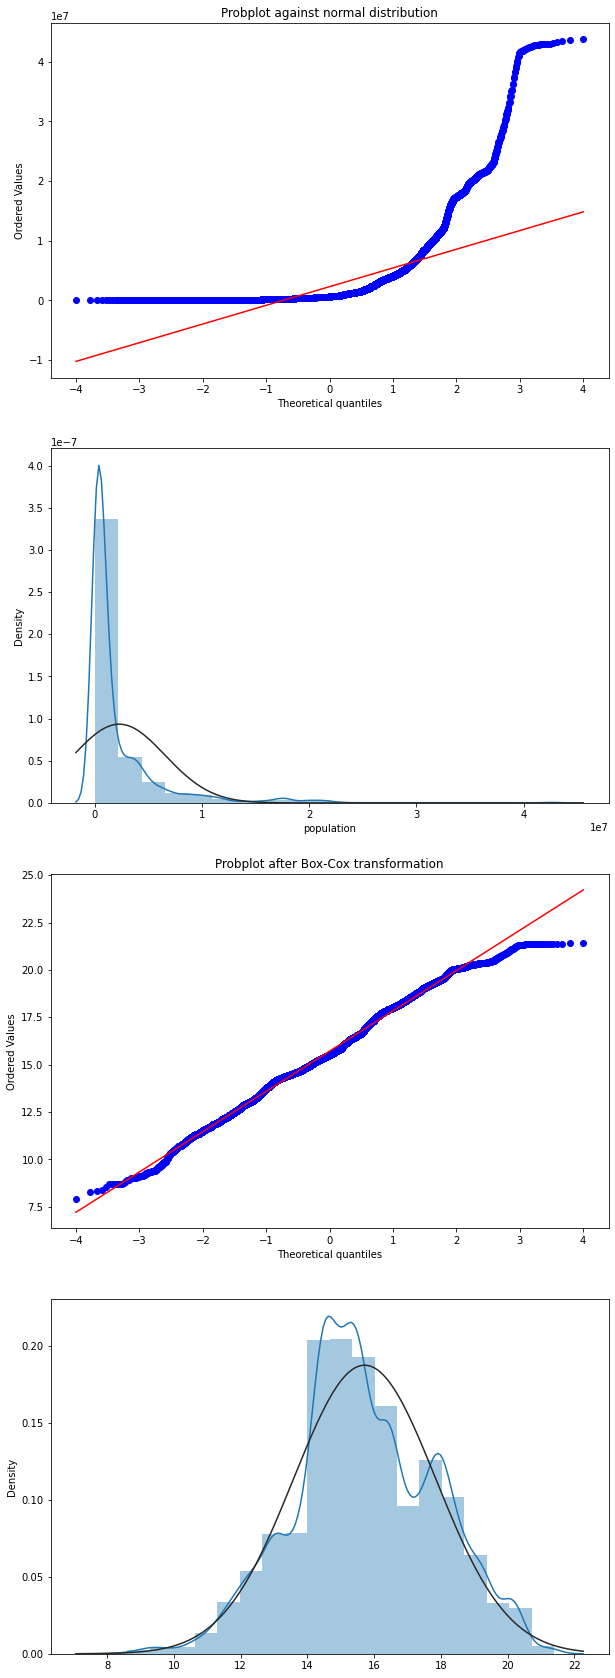

In [48]:
fig = plt.figure(figsize=(10,30))
ax1 = fig.add_subplot(411)
stats.probplot(df["population"], dist=stats.norm,plot=ax1)
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(412)
sns.distplot(df["population"],bins = 20,fit=norm)
ax3 = fig.add_subplot(413)
x, _ = stats.boxcox(df["population"])
stats.probplot(x, dist=stats.norm,plot=ax3)
ax3.set_title('Probplot after Box-Cox transformation')
ax4 = fig.add_subplot(414)
sns.distplot(x,bins = 20,fit=norm)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



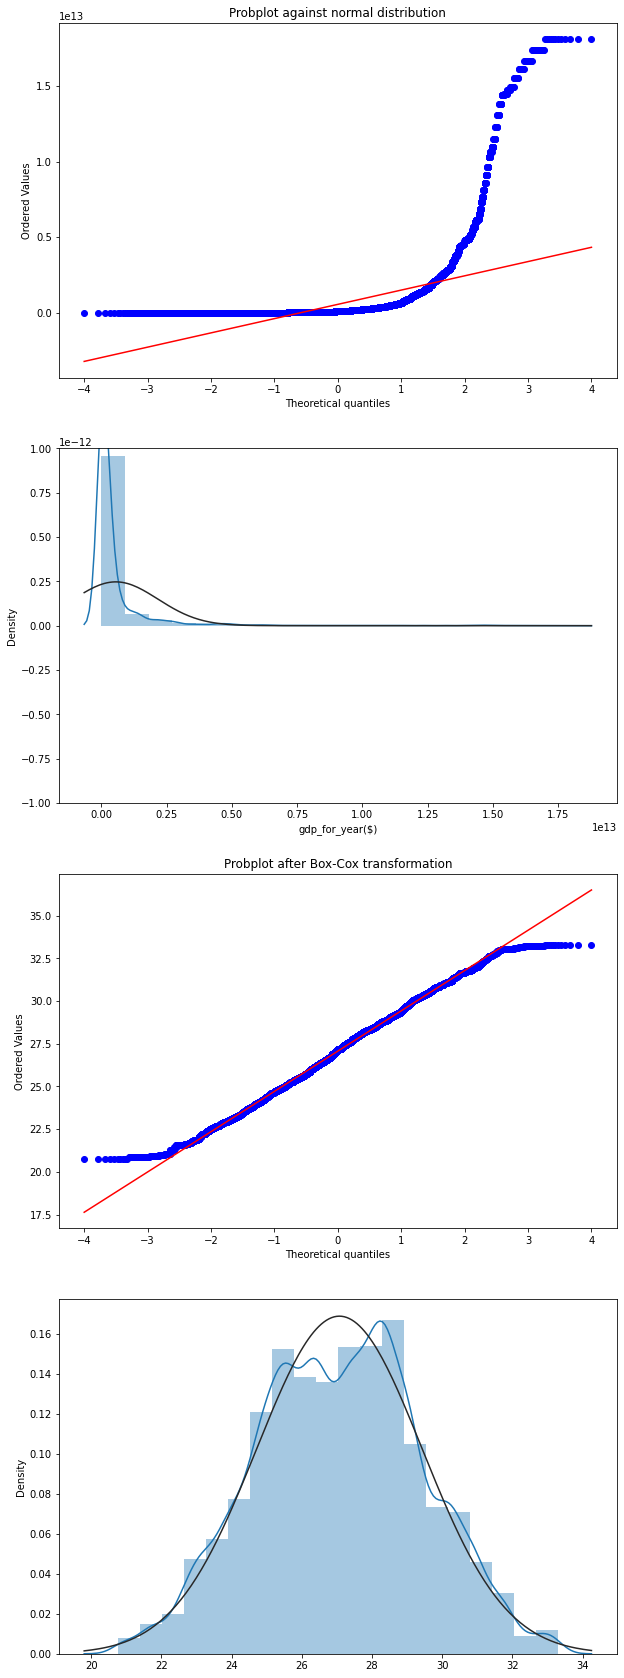

In [49]:
fig = plt.figure(figsize=(10,30))
ax1 = fig.add_subplot(411)
stats.probplot(df["gdp_for_year($)"], dist=stats.norm,plot=ax1)
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(412)
sns.distplot(df["gdp_for_year($)"],bins = 20,fit=norm)
ax3 = fig.add_subplot(413)
x, _ = stats.boxcox(df["gdp_for_year($)"])
stats.probplot(x, dist=stats.norm,plot=ax3)
ax3.set_title('Probplot after Box-Cox transformation')
ax4 = fig.add_subplot(414)
sns.distplot(x,bins = 20,fit=norm)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



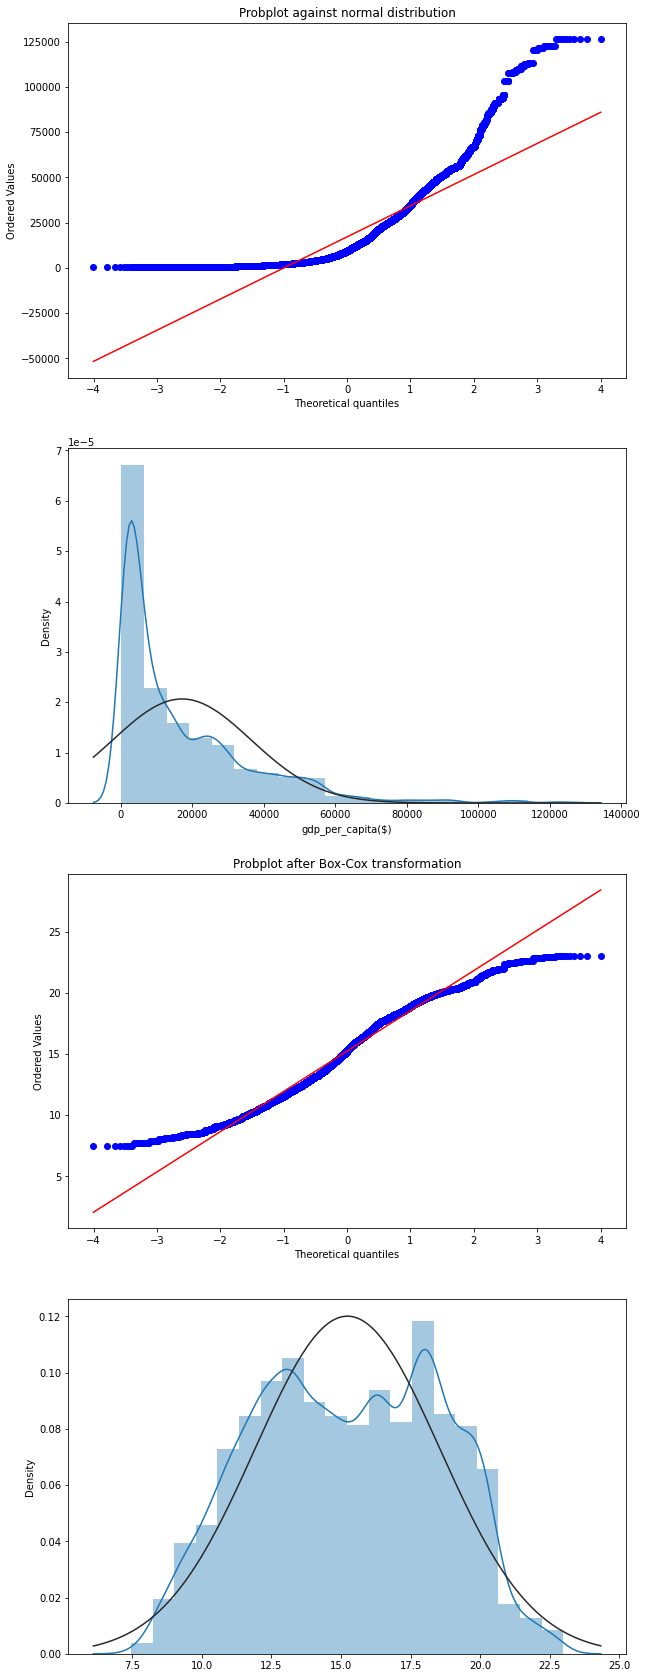

In [50]:
fig = plt.figure(figsize=(10,30))
ax1 = fig.add_subplot(411)
stats.probplot(df["gdp_per_capita($)"], dist=stats.norm,plot=ax1)
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(412)
sns.distplot(df["gdp_per_capita($)"],bins = 20,fit=norm)
ax3 = fig.add_subplot(413)
x, _ = stats.boxcox(df["gdp_per_capita($)"])
stats.probplot(x, dist=stats.norm,plot=ax3)
ax3.set_title('Probplot after Box-Cox transformation')
ax4 = fig.add_subplot(414)
sns.distplot(x,bins = 20,fit=norm)

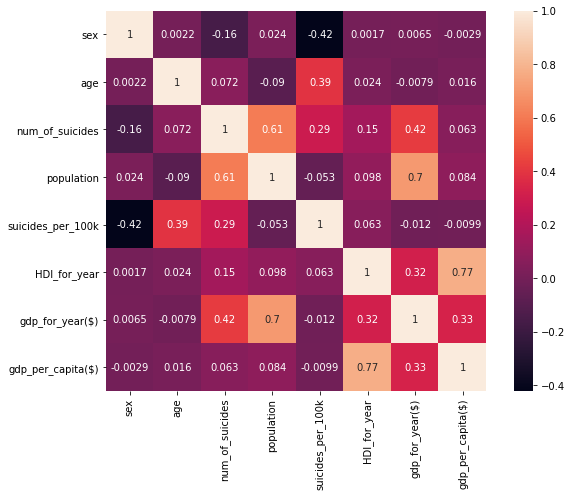

In [51]:
corr_matrix = df.iloc[:,2:].corr()
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(corr_matrix, vmax=1, square=True,annot = True)

In [52]:
def plot_bubble_chart(year,age):
  temp_dict = {x:y for x,y in zip(np.sort(df["age"].unique()),['kids','teenagers', 'young adults', 'adults',
        'elderly','retirees'])}
  fig = px.scatter(df[(df['year'] == year) & (df["age"] == age)], x="suicides_per_100k", y="population",
        size="gdp_for_year($)", color = "sex",
              hover_name="country", log_x=True, size_max=60)
  fig.update_layout(
  title='Number of suicides of {} vs Population of their country, {}'.format(temp_dict[age],year),
  xaxis=dict(
      title='Number of suicides of {}'.format(temp_dict[age]),
      gridcolor='white',
      type='log',
      gridwidth=2,
  ),
  yaxis=dict(
      title='Population of their country',
      gridcolor='white',
      gridwidth=2,
  ),
  paper_bgcolor='rgb(255, 255, 255)',
  plot_bgcolor='rgb(255, 255, 255)',
  height = 600,
  width = 1500
  )
  fig.show()

In [53]:
plot_bubble_chart(2015,19)

In [54]:
temp_df = df[['country','year','sex',"suicides_per_100k"]].groupby(["country","year","sex"]).sum().reset_index()
  
def plot_line_plot(country):
    fig = px.line(temp_df[temp_df["country"] == country], x='year', y="suicides_per_100k", color='sex',title=country)
    fig.update_layout(height=800,width = 1500)
    fig.show()

In [55]:
plot_line_plot("Poland")

In [56]:
def plot_bar_plot(country):
  t = temp_df.groupby(["country","year","sex"]).sum().reset_index()[["country","year","sex","suicides_per_100k"]]
  fig = px.bar(t[(t["country"] == country)],
               x="year", y='suicides_per_100k',color = "sex")
  fig.update_layout(height=800,width = 1500)
  fig.show()

In [57]:
plot_bar_plot("Poland")

In [58]:
def plot_violin(df):
  fig = px.violin(df, y="suicides_per_100k", color="sex",
                violinmode='overlay',
                hover_data=["year","suicides_per_100k","country"])
  fig.show()
  fig.update_layout(height=800,width = 1500)
plot_violin(df)

In [59]:
def plot_violin_1(df):
  fig = px.violin(df, y="suicides_per_100k",x="year", color="sex",
                 violinmode='overlay', points="all",
                 hover_data=["year","country","age","suicides_per_100k"])
  fig.update_layout(height=800,width = 3000)
  fig.show()
plot_violin_1(df)
 
  

In [60]:
def plot_violin_2(df):
  fig = px.violin(df, y="num_of_suicides",x="year", color="sex",
                 violinmode='overlay', points="all",
                 hover_data=["year","country","age","suicides_per_100k"])
  fig.update_layout(height=800,width = 3000)
  fig.show()
plot_violin_2(df)

In [61]:
def plot_ridgeline(df):
  fig, axes = joypy.joyplot(df
                          , column=["suicides_per_100k"]
                          , overlap=2.5
                          , by="country"
                          , ylim = "own"
                          , yrot = 1.0
              
                          , fill=True
                          , figsize=(15,25)
                          , legend=False
                          , xlabels=True
                          , ylabels=True
                          , colormap=cm.autumn_r
                          , alpha=0.6
                          , linewidth=.5
                          , linecolor='w'
                          , background='grey'
                          , fade=True)
  plt.xlabel('Number of suicides per 100.000 people', fontsize=14, color='grey', alpha=1)
  plt.ylabel('Country', fontsize=8, color='grey', alpha=1)
  plt.show()

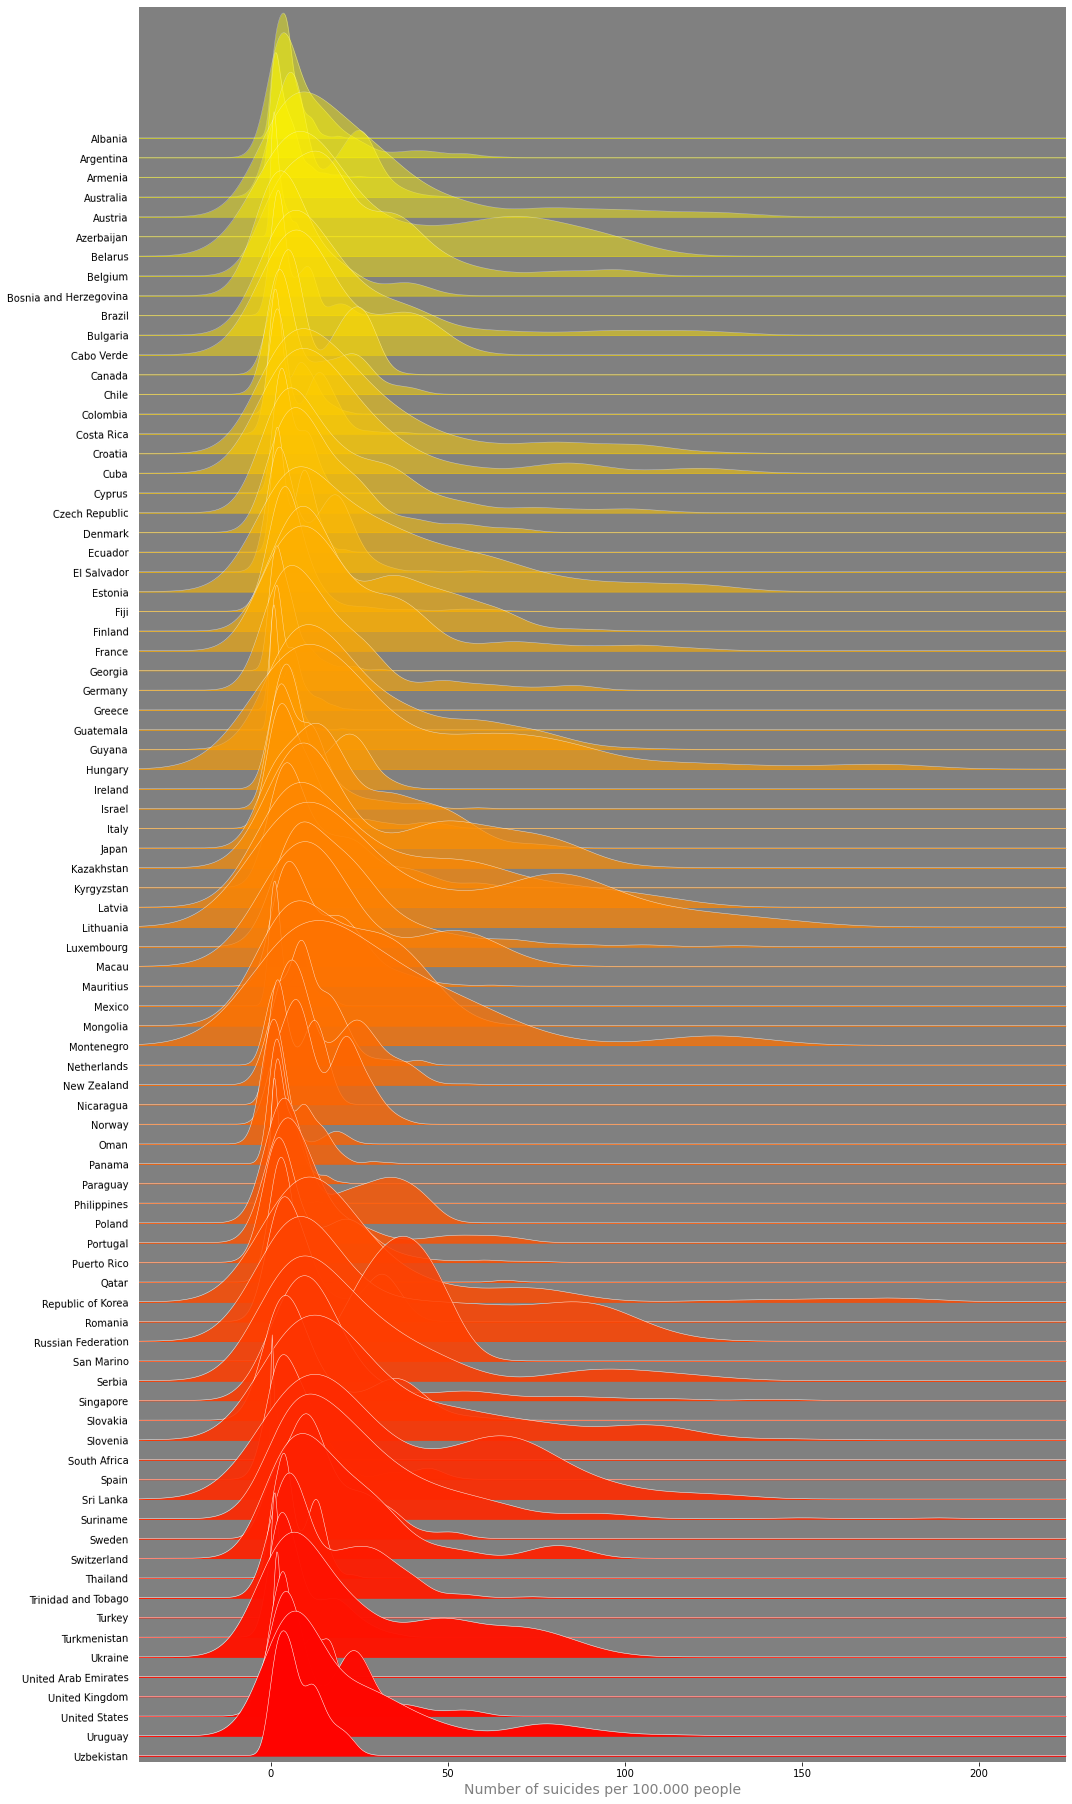

In [62]:
plot_ridgeline(df)

In [63]:
def plot_wc(df):
  wd_df = df.groupby("country").sum()["suicides_per_100k"].reset_index()
  wd_df = wd_df[wd_df["suicides_per_100k"] >= 891.13]
  wd_df["suicides_per_100k"] = wd_df["suicides_per_100k"] // np.min(wd_df["suicides_per_100k"])
  wd_df["country"] = wd_df["country"].apply(lambda x: "".join(x.split(" ")) if " " in x else x)
  wd_df["suicides_per_100k"] = wd_df["suicides_per_100k"].astype("int64")
  text = ""
  for country,num in wd_df.values:
    while num > 0:
      text += country + " "
      num -= 1
  text = " ".join(random.sample(text.split(" "),k=len(text.split(" "))))
  return text

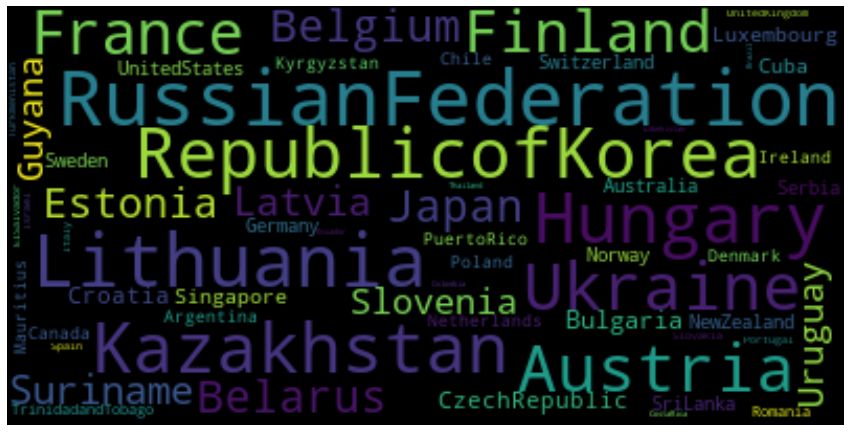

In [64]:
wordcloud = WordCloud(max_words=76).generate(plot_wc(df))
plt.subplots(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [65]:
with open('country-codes-lat-long-alpha3.json') as myfile:
  data = json.load(myfile)



In [66]:
temp_data = {"Country": [x["country"] for x in data['ref_country_codes'] if x["country"] in df[(df["HDI_for_year"].isna() == False)]["country"].unique()],
             "Longitude": [x["longitude"] for x in data['ref_country_codes'] if x["country"] in df[(df["HDI_for_year"].isna() == False)]["country"].unique()],
             "Latitude": [x["latitude"] for x in data['ref_country_codes'] if x["country"] in df[(df["HDI_for_year"].isna() == False)]["country"].unique()]}
df_for_visual = pd.DataFrame(temp_data)

In [67]:
temp_df = df[(df["HDI_for_year"].isna() == False) ][["country","HDI_for_year"]]

In [68]:
HDI = []
for country in temp_df["country"].unique():
  for x in df_for_visual["Country"].unique():
    if country == x:
      HDI.append(np.average(temp_df[temp_df["country"] == x]['HDI_for_year'].unique()))
    

In [69]:
df_for_visual["HDI"] = HDI
df_for_visual["text"] = df_for_visual["Country"] + " " + df_for_visual["HDI"].astype(str)

In [70]:
fig = go.Figure(data = go.Scattergeo(
    lon = df_for_visual["Longitude"],
    lat = df_for_visual["Latitude"],
    text = df_for_visual["text"],
    mode = "markers",
    marker = dict(
        size = 12,
        opacity = 0.8,
        reversescale = True,
        autocolorscale = True,
        symbol = 'square',
        line = dict(
            width = 1,
            color = 'rgba(102, 102, 102)'
        ),
        cmin = 0,
        color = df_for_visual["HDI"],
        #cmax = np.average(df_for_visual["HDI"]),
        colorbar_title = "Human Development Index"
    )
))

fig.update_layout(
    title = "Human Development Index",
    geo = dict(
        scope = "world",
        showland = True,
    ),
    height=900, 
    margin={"r":0,"t":0,"l":0,"b":0}
)
fig.update_geos(projection_type="natural earth")
fig.show()


In [71]:
def plot_map(df,year):
  temp_data = {"country": [x["country"] for x in data['ref_country_codes'] if x["country"] in df["country"].unique()],
              "Longitude": [x["longitude"] for x in data['ref_country_codes'] if x["country"] in df["country"].unique()],
              "Latitude": [x["latitude"] for x in data['ref_country_codes'] if x["country"] in df["country"].unique()]}
  df_for_visual = pd.DataFrame(temp_data)
  temp_df = df[['country','year',"suicides_per_100k"]].groupby(["country","year"]).sum().reset_index()
  result = pd.merge(df_for_visual,temp_df, on='country')
  result["text"] = result["country"] + " " + result["suicides_per_100k"].astype(str)
  fig = go.Figure(data = go.Scattergeo(
      lon = result[result["year"] == year]["Longitude"],
      lat = result[result["year"] == year]["Latitude"],
      text = result[result["year"] == year]["text"],
      mode = "markers",
      marker = dict(
          size = 12,
          opacity = 0.8,
          reversescale = True,
          autocolorscale = True,
          symbol = 'square',
          line = dict(
              width = 1,
              color = 'rgba(102, 102, 102)'
          ),
          cmin = 0,
          color = result[result["year"] == year]["suicides_per_100k"],
          #cmax = np.average(result["suicides_per_100k"]),
          colorbar_title = "Number of suicides per 100 000 people in {}".format(year)
      )
  ))

  fig.update_layout(
      title = "Number of suicides per 100 000 people in {}".format(year),
      geo = dict(
          scope = "world",
          showland = True,
      ),
      height=900, 
      margin={"r":0,"t":0,"l":0,"b":0}
  )
  fig.update_geos(projection_type="natural earth")
  fig.show()

In [72]:
plot_map(df,2010)

In [73]:
df = df.drop(columns=["HDI_for_year"])

In [74]:
df.columns

Index(['country', 'year', 'sex', 'age', 'num_of_suicides', 'population',
       'suicides_per_100k', 'gdp_for_year($)', 'gdp_per_capita($)',
       'generation'],
      dtype='object')

In [75]:
df_cleaned = df[["sex","age","population","suicides_per_100k","gdp_for_year($)","gdp_per_capita($)"]]

In [76]:
X = df_cleaned[["sex","age","population","gdp_for_year($)"]]
y= df_cleaned["suicides_per_100k"]

In [77]:
for column in X.columns:
  if column != "sex":
    box_x,_ = stats.boxcox(X[column])
    X[column] = box_x
    norm = MinMaxScaler()
    X[column] = norm.fit_transform(X[column].values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [78]:
y,_ = stats.boxcox(y)


In [79]:
y = pd.Series(y)

In [80]:
X.head()

sex       age  population  gdp_for_year($)
0    0  0.242878    0.491376         0.166189
1    0  0.644940    0.489837         0.166189
2    1  0.242878    0.483868         0.166189
3    0  1.000000    0.238862         0.166189
4    0  0.424876    0.478552         0.166189

In [81]:
y

0        2.223528
1        1.882752
2        1.789850
3        1.724626
4        1.307583
           ...   
22057    1.184568
22058    1.023030
22059    0.824529
22060    0.534339
22061    0.390069
Length: 22062, dtype: float64

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [83]:
def display_scores(scores):
  print("Scores:", scores)
  print("Average:", scores.mean())
  print("Standard deviation:", scores.std())

# **Linear Regression**

In [ ]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train,y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
scores = cross_val_score(lin_reg_model, X_train, y_train,scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
display_scores(scores)

Scores: [-1.37564898 -1.38051319 -1.38657342 -1.40813903 -1.3942468  -1.38085296
 -1.41828889 -1.35928001 -1.4302117  -1.38595375]
Average: -1.3919708714548735
Standard deviation: 0.020191359619137927


# **Support Vector Regressor**

In [ ]:
vec_reg_model = SVR()
vec_reg_model.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
scores = cross_val_score(vec_reg_model, X_train, y_train,scoring="neg_root_mean_squared_error", cv=5)

In [ ]:
display_scores(scores=scores)

Scores: [-1.16556728 -1.1622466  -1.16574925 -1.1580498  -1.18067364]
Average: -1.1664573136521474
Standard deviation: 0.007639554029474615


# **Random Forest Regressor**

In [ ]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
scores = cross_val_score(forest_reg, X_train, y_train,scoring='neg_root_mean_squared_error' ,cv=6)

In [ ]:
display_scores(scores=scores)

Scores: [-0.95493729 -0.94827352 -0.96685512 -0.97043953 -0.96690268 -0.98118983]
Average: -0.9647663282861467
Standard deviation: 0.010641634546088527


In [ ]:
y_pred = forest_reg.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test,y_pred,squared=False)

In [ ]:
rmse

0.942465350949208

In [ ]:
def view_test_vs_pred(x_test,y_test,y_pred,n):
  print("*" * 50)
  for i in range(n):
    r = random.randint(0,len(y_test))
    print("Sex: {}  Age: {}  Population: {}  Gdp: {}".format(X_test.iloc[r,0],X_test.iloc[r,1],X_test.iloc[r,2],X_test.iloc[r,3]))
    print("Actual value: {}\nPredicted value: {}\nRMSE: {}".format(y_test[r],y_pred[r],np.sqrt((y_pred[r] - y_test[r])**2)))
    print("*" * 50)

In [ ]:
view_test_vs_pred(X_test,y_test.to_numpy(),y_pred,10)

**************************************************
Sex: 0  Age: 0.6449404643052515  Population: 0.8088136413959419  Gdp: 0.6540323005913733
Actual value: 3.098209957725753
Predicted value: 3.2309102355229125
RMSE: 0.13270027779715932
**************************************************
Sex: 0  Age: 0.42487623160330323  Population: 0.3785121825985952  Gdp: 0.38070320173816596
Actual value: 4.567090153829655
Predicted value: 4.261786120974296
RMSE: 0.3053040328553589
**************************************************
Sex: 1  Age: 0.24287817800440792  Population: 0.37766972173068636  Gdp: 0.264135455797448
Actual value: 1.8852540881902795
Predicted value: 2.1224301151071914
RMSE: 0.23717602691691186
**************************************************
Sex: 0  Age: 0.0  Population: 0.49743462827242557  Gdp: 0.3416924031537023
Actual value: -0.1044818172875731
Predicted value: 0.0935059666286334
RMSE: 0.1979877839162065
**************************************************
Sex: 0  Age: 0.242878178

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1200, stop = 1400, num = 25)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 40, num = 2)]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3, 4]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
random_forest = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = 40, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 64.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 82.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1300}

In [ ]:
rf_best = rf_random.best_estimator_
rf_best.feature_importances_,X_train.columns

(array([0.20445331, 0.43231901, 0.20363123, 0.15959645]),
 Index(['sex', 'age', 'population', 'gdp_for_year($)'], dtype='object'))

In [ ]:
scores = cross_val_score(rf_best,X_train,y_train,scoring =  'neg_root_mean_squared_error',cv=6)

In [ ]:
display_scores(scores)

Scores: [-0.94806924 -0.93844305 -0.95900874 -0.96098238 -0.95823412 -0.97101829]
Average: -0.9559593029770667
Standard deviation: 0.010291990281858536


In [ ]:
y_pred = rf_best.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test,y_pred,squared=False)

In [ ]:
rmse

0.9316582176936782

In [ ]:
view_test_vs_pred(X_test,y_test.to_numpy(),y_pred,10)

**************************************************
Sex: 0  Age: 0.6449404643052515  Population: 0.3126361451583064  Gdp: 0.09213639368514825
Actual value: 3.5409208201680062
Predicted value: 3.6321389056390463
RMSE: 0.09121808547104004
**************************************************
Sex: 1  Age: 0.24287817800440792  Population: 0.5079080676578547  Gdp: 0.20823949478022774
Actual value: 1.2927731480700406
Predicted value: 1.2666777877848128
RMSE: 0.026095360285227853
**************************************************
Sex: 0  Age: 0.6449404643052515  Population: 0.3623067504932227  Gdp: 0.06811084009022572
Actual value: 6.132991630541906
Predicted value: 5.438787626351433
RMSE: 0.6942040041904729
**************************************************
Sex: 1  Age: 0.24287817800440792  Population: 0.45144246496456963  Gdp: 0.5015007190643368
Actual value: 1.5068727408112819
Predicted value: 2.2450685879175163
RMSE: 0.7381958471062344
**************************************************
Sex: 1

# **Gradient Boosting**

In [ ]:
grad_boost_reg = GradientBoostingRegressor()
grad_boost_reg.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
scores = cross_val_score(grad_boost_reg,X_train,y_train,scoring='neg_root_mean_squared_error' ,cv=6)

In [ ]:
display_scores(scores)

Scores: [-1.11698484 -1.08357414 -1.10993142 -1.11665943 -1.09633536 -1.12988107]
Average: -1.1088943768982396
Standard deviation: 0.015089245182891706


# **Lasso Regression**

In [ ]:
lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
scores = cross_val_score(lasso_reg,X_train,y_train,scoring='neg_root_mean_squared_error' ,cv=10)

In [ ]:
display_scores(scores)

Scores: [-1.92714671 -1.94151637 -1.93102164 -1.93437112 -1.97007521 -1.93303917
 -1.97033668 -1.93474423 -1.96650975 -1.93214344]
Average: -1.9440904312949552
Standard deviation: 0.016666992479827628


# **KNN Regressor**

In [ ]:
knn_reg = neighbors.KNeighborsRegressor()
knn_reg.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
scores = cross_val_score(knn_reg,X_train,y_train,scoring='neg_root_mean_squared_error' ,cv=10)

In [ ]:
display_scores(scores)

Scores: [-0.95379632 -1.03163077 -0.94148902 -1.02786452 -0.98482729 -0.99215834
 -1.01836529 -0.9801497  -1.04984921 -0.99680382]
Average: -0.9976934278951897
Standard deviation: 0.03286370417877782


# **ANN**

In [ ]:
X_train.shape[1:]

(4,)

In [ ]:
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Dense(units = 64, activation='relu',kernel_initializer='normal'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(units = 1, activation='linear')
])




model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse','mae'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 641
Trainable params: 513
Non-trainable params: 128
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,batch_size=64,epochs=125,validation_split=0.2,validation_batch_size=64,verbose=1)

Epoch 1/125
207/207 [==============================] - 1s 2ms/step - loss: 3.8892 - mse: 3.8892 - mae: 1.5720 - val_loss: 3.3249 - val_mse: 3.3249 - val_mae: 1.4806
Epoch 2/125
207/207 [==============================] - 0s 2ms/step - loss: 1.5943 - mse: 1.5943 - mae: 0.9920 - val_loss: 2.6358 - val_mse: 2.6358 - val_mae: 1.3097
Epoch 3/125
207/207 [==============================] - 0s 2ms/step - loss: 1.5741 - mse: 1.5741 - mae: 0.9866 - val_loss: 1.7122 - val_mse: 1.7122 - val_mae: 1.0448
Epoch 4/125
207/207 [==============================] - 0s 2ms/step - loss: 1.5595 - mse: 1.5595 - mae: 0.9819 - val_loss: 1.4958 - val_mse: 1.4958 - val_mae: 0.9589
Epoch 5/125
207/207 [==============================] - 0s 2ms/step - loss: 1.5634 - mse: 1.5634 - mae: 0.9836 - val_loss: 1.4310 - val_mse: 1.4310 - val_mae: 0.9342
Epoch 6/125
207/207 [==============================] - 0s 2ms/step - loss: 1.5691 - mse: 1.5691 - mae: 0.9846 - val_loss: 1.4312 - val_mse: 1.4312 - val_mae: 0.9353
Epoch 7/12

In [ ]:
model.evaluate(X_test,y_test)

173/173 [==============================] - 0s 953us/step - loss: 1.3959 - mse: 1.3959 - mae: 0.9232


[1.3959108591079712, 1.3959108591079712, 0.9231756329536438]